In [27]:
import os
import numpy as np
from nanowire.optics.simulate import Simulator
from nanowire.optics.postprocess import Simulation
from nanowire.optics.utils.utils import setup_sim
from nanowire.optics.utils.config import Config
from nanowire.optics.utils.geometry import *
import scipy.constants as consts
import scipy.integrate as intg
import IPython.display as disp
import matplotlib.pyplot as plt
plt.style.use(['presentation'])
%load_ext autoreload 
%autoreload 2
%load_ext ipycache

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Utility Functions

In [114]:
def integrate1d(arr, xvals):
    x_integral = intg.trapz(arr, x=xvals, axis=0)
    return x_integral

def integrate2d(arr, xvals, yvals):
    x_integral = intg.trapz(arr, x=xvals, axis=0)
    y_integral = intg.trapz(x_integral, x=yvals, axis=0)
    return y_integral

def integrate3d(arr, xvals, yvals, zvals):
    ##print("Layer: {}".format(layer_obj.name))
    ##print("Layer Start Ind: {}".format(layer_obj.istart))
    ##print("Layer End Ind: {}".format(layer_obj.iend))
    ##print(z_vals)
    z_integral = intg.trapz(arr, x=zvals, axis=0)
    x_integral = intg.trapz(z_integral, x=xvals, axis=0)
    y_integral = intg.trapz(x_integral, x=yvals, axis=0)
    return y_integral

def compute_fluxes(sim):
    fluxes = sim.data['fluxes']
    total_incident_power = .5*sim.period**2/Zo*np.absolute(fluxes['Air'][0])
    total_reflected_power = .5*sim.period**2/Zo*np.absolute(fluxes['Air'][1])
    total_transmitted_power = .5*sim.period**2/Zo*np.absolute(sum(fluxes['Substrate_bottom']))
    total_absorbed_power = total_incident_power - total_reflected_power - total_transmitted_power
    #print('Total Incident Power = {}'.format(total_incident_power))
    #print('Total Reflected Power = {}'.format(total_reflected_power))
    #print('Total Transmitted Power = {}'.format(total_transmitted_power))
    #print('Total Absorbed Power = {}'.format(total_absorbed_power))
    summed_absorbed_power = 0
    abs_dict_fluxmethod = {}
    for layer, (forw_top, back_top) in fluxes.items():
        if '_bottom' in layer:
            continue
        bottom = layer+'_bottom'
        forw_bot, back_bot = fluxes[bottom] 
        #print('-'*25)
        #print('Layer: {}'.format(layer))
        #print('Forward Top: {}'.format(forw_top))
        #print('Backward Top: {}'.format(back_top))
        #print('Forward Bottom: {}'.format(forw_bot))
        #print('Backward Bottom: {}'.format(back_bot))
        P_in = forw_top + -1*back_bot
        P_out = forw_bot + -1*back_top
        #print('Power Entering Layer: {}'.format(P_in))
        #print('Power Leaving Layer: {}'.format(P_out))
        P_lost = P_in - P_out
        P_abs = .5*P_lost*(sim.period**2)/Zo
        abs_dict_fluxmethod[layer] = P_abs 
        #print('Absorbed in Layer: {}'.format(P_abs))
        summed_absorbed_power += P_abs
    #print('-'*25)
    #print('Summed Absorption= {}'.format(summed_absorbed_power))
    return abs_dict_fluxmethod, summed_absorbed_power

def get_intmethod_abs(sim_proc):
    abs_dict_intmethod = {}
    int_method_total = 0
    freq = sim_proc.conf[("Simulation","params","frequency","value")]
    Esq = sim_proc.normEsquared()
    for layer_name, layer_obj in sim_proc.layers.items():
        #print("Layer: {}".format(layer_name))
        base_unit = sim_proc.conf[('Simulation', 'base_unit')]
        n_mat, k_mat = layer_obj.get_nk_matrix(freq)
        # n and k could be functions of space, so we need to multiply the
        # fields by n and k before integrating
        arr = Esq[layer_obj.slice]
        z_vals = sim_proc.Z[layer_obj.istart:layer_obj.iend]
        res = integrate3d(arr*n_mat*k_mat,sim_proc.X, sim_proc.Y, z_vals)
        if np.isnan(res):
            #print("Result is nan!")
            res = 0
        p_abs_imag = 2*np.pi*freq*consts.epsilon_0*res*base_unit
        abs_dict_intmethod[layer_name] = p_abs_imag
        #disp.display_latex("$P_{abs} = \\frac{\omega}{2} Im(\epsilon) \int |E|^2 dV"+" = {}$".format(p_abs_imag), raw=True)
        int_method_total += p_abs_imag
    #print("Integral Method Total Absorption: {}".format(int_method_total))
    return abs_dict_intmethod, int_method_total

def get_errors(abs_dict_intmethod, abs_dict_fluxmethod, int_method_total, flux_method_total):
    errors = {}
    for key in abs_dict_fluxmethod.keys():
        fm = abs_dict_fluxmethod[key]
        im = abs_dict_intmethod[key]
        diff = np.real(fm - im)
        try:
            pdiff = 100*abs(diff)/fm
        except ZeroDivisionError:
            pdiff = None
            pass
        #print('-'*25)
        #print("Layer: {}".format(key))
        #print("Flux Method: {}".format(fm))
        #print("Integral Method: {}".format(im))
        #print("Diff: {}".format(diff))
        #print("Percent Diff: {}".format(pdiff))
        errors[key] = (diff, pdiff)
    pdiff_total = 100*abs(flux_method_total - int_method_total)/flux_method_total
    #print('-'*25)
    #print("Total Percent Difference: {}".format(pdiff_total))
    errors['total'] = pdiff_total
    return errors

def get_layer_absorption(sim, layer, plane_samps, zsamps):
    layer_results = []
    freq = sim.conf[('Simulation', 'params', 'frequency')]
    base_unit = sim.conf[('Simulation', 'base_unit')]
    for zsamp in zsamps:
        sim.conf['Simulation']['x_samples'] = plane_samps
        sim.conf['Simulation']['y_samples'] = plane_samps
        sim.conf['Simulation']['z_samples'] = zsamp
        sim.xsamps = plane_samps
        sim.ysamps = plane_samps
        sim.zsamps = zsamp
        sim.make_coord_arrays()
        sim_proc = Simulation(simulator=sim)
        layer_obj = sim_proc.layers[layer]
        n_mat, k_mat = layer_obj.get_nk_matrix(freq)
        Esq = np.zeros((zsamp, plane_samps, plane_samps))
        z_vals = np.linspace(layer_obj.start, layer_obj.end, zsamp)
        for i, z in enumerate(z_vals):
            Ex, Ey, Ez, _, _, _ = sim.compute_fields_on_plane(z, plane_samps, plane_samps)
            Esq_plane = np.abs(Ex)**2 + np.abs(Ey)**2 + np.abs(Ez)**2 
            Esq[i, :, :] = Esq_plane
        result = integrate3d(n_mat*k_mat*Esq, sim.X, sim.Y, z_vals)
        result = 2*np.pi*freq*consts.epsilon_0*result*base_unit
        layer_results.append((zsamp, result))
    print("Done with get_layer_absorption!")
    return layer_results

# NW w/ Shell

In [59]:
conf = Config('AbsorptionTest.yml')
sim = Simulator(conf)
sim.setup()
Zo = consts.physical_constants['characteristic impedance of vacuum'][0]
sim.load_state()

In [60]:
sim.get_fluxes()
sim.data['fluxes'] = {record[0].decode():(record[1], record[2]) for record in sim.data['fluxes']}
abs_dict_fluxmethod, flux_method_total = compute_fluxes(sim)
sim.save_state()

In [61]:
print(abs_dict_fluxmethod)
print(sim.data['fluxes'])

{'ITO': (0.004602583734458726+0j), 'Air': 0j, 'NW_AlShell': (0.043291132892704587+0j), 'Substrate': (0.019302828446036237+0j)}
{'Air_bottom': ((930.44855212959192-7.1054273576010019e-15j), (-79.745808052105829+7.1054273576010019e-15j)), 'NW_AlShell_bottom': ((282.80131578128714+0.43816566378263566j), (-9.4750477935732231-0.43816566378263566j)), 'Substrate': ((273.32626798770224+0j), 0j), 'Substrate_bottom': ((40.623528430133746+0j), 0j), 'ITO': ((863.95502596820461+0.016166442965833028j), (-13.252281890906113-0.016166442965833028j)), 'ITO_bottom': ((808.62904622566725-0.54453340245274973j), (-13.41215216490262+0.54453340245274973j)), 'NW_AlShell': ((797.97198634056872+0.096105127033460747j), (-2.7550922797742263-0.096105127033460747j)), 'Air': ((930.44855212959192+0j), (-79.745808052105829+0j))}


## Per Layer Convergence

In [112]:
ito_cache = os.path.join(sim.dir, 'ito_results.pkl')

### ITO 

Here the number of in plane sampling points doesn't really matter, because the field should be constant in the plane (with some slight variation due to
reflections and whatnot). I've found the difference in the results between 50 and 100 in plane sampling points is 0 for all values of the z sampling, so I'm
sticking with that number

In [63]:
%%cache $ito_cache ito_results 
ito_results = get_layer_absorption(sim, "ITO", 50, range(50, 200, 10))

Done with get_layer_absorption!


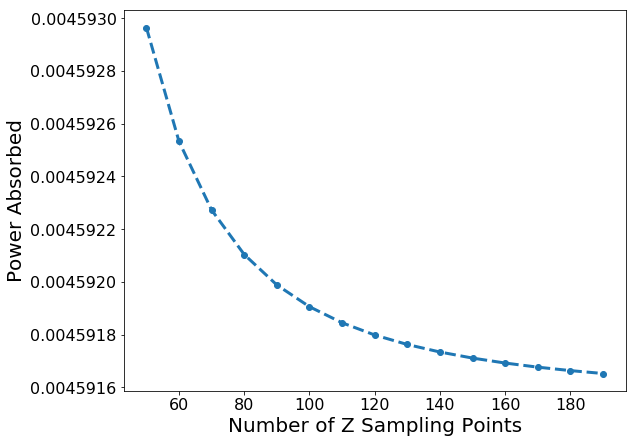

In [64]:
samps, res = map(np.array, zip(*ito_results))
rel_diffs = [100*abs(res[i] - res[-1])/res[i] for i in range(len(res))]
plt.figure()
plt.plot(samps, res, '--o')
#plt.plot(samps, rel_diffs, '--o')
plt.ylabel("Power Absorbed")
plt.xlabel("Number of Z Sampling Points")
plt.show()

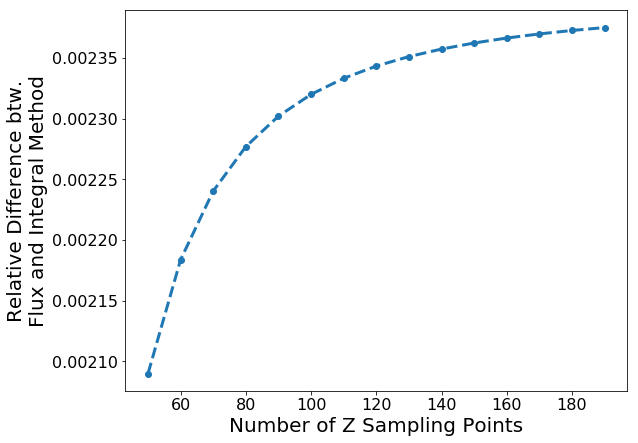

In [65]:
diff = np.abs(res - abs_dict_fluxmethod['ITO'])/np.abs(abs_dict_fluxmethod['ITO'])
plt.figure()
plt.plot(samps, diff, '--o')
#plt.plot(samps[:-1], rel_diffs, '--o')
plt.ylabel("Relative Difference btw.\nFlux and Integral Method")
plt.xlabel("Number of Z Sampling Points")
plt.show()

### NW

Here we need to do some convergence testing in both the z sampling and the in plane sampling, because the NW layer has in plane patterning that will 
significantly affect the field results

In [113]:
nw_cache = os.path.join(sim.dir, 'nw_results.pkl')

In [75]:
%%cache $nw_cache nw_results 
nw_results = {}
for plane_samps in range(150, 425, 25):
    plane_results = get_layer_absorption(sim, "NW_AlShell", plane_samps, range(100, 425, 25))
    nw_results[plane_samps] = plane_results
    #nw_plane_results.append((plane_samps, plane_results[0][1])) 
print(nw_results)

Done with get_layer_absorption!
Done with get_layer_absorption!
Done with get_layer_absorption!
Done with get_layer_absorption!
Done with get_layer_absorption!
Done with get_layer_absorption!
Done with get_layer_absorption!
Done with get_layer_absorption!
Done with get_layer_absorption!
Done with get_layer_absorption!
Done with get_layer_absorption!
{400: [(100, 0.04423749375962046), (125, 0.044231613579893372), (150, 0.044227625782687283), (175, 0.044224749958182763), (200, 0.044222581309894038), (225, 0.044220889403046949), (250, 0.0442195336499068), (275, 0.04421842353576691), (300, 0.044217498217953823), (325, 0.044216715327504832), (350, 0.044216044475220449), (375, 0.044215463310667016), (400, 0.044214955037142338)], 225: [(100, 0.044544174215376479), (125, 0.044538267289775391), (150, 0.044534262499174929), (175, 0.044531374732217167), (200, 0.04452919716007811), (225, 0.044527498304415672), (250, 0.044526136976178535), (275, 0.044525022285374444), (300, 0.04452409314118181), (3

In [86]:
nw_results_zsamp_keys = {}
for plane_samp, results in nw_results.items():
    for zsamp, power in results:
        if zsamp not in nw_results_zsamp_keys:
            nw_results_zsamp_keys[zsamp] = [(plane_samp, power)]
        else:
            nw_results_zsamp_keys[zsamp].append((plane_samp, power))
nw_results_zsamp_keys = {key: sorted(val) for key, val in nw_results_zsamp_keys.items()}

11
Zsamp: 225
[(150, 0.04444907824076362), (175, 0.044608988890896373), (200, 0.044357430720288075), (225, 0.044527498304415672), (250, 0.04430852147815896), (275, 0.044416530356564676), (300, 0.044236194984259722), (325, 0.044343467007982529), (350, 0.044244136818270122), (375, 0.044296792042543248), (400, 0.044220889403046949)]
Zsamp: 100
[(150, 0.04446559248354412), (175, 0.044625550332892172), (200, 0.044373991655475037), (225, 0.044544174215376479), (250, 0.044325082852263241), (275, 0.044433110600948754), (300, 0.04425272076326256), (325, 0.044360056867354732), (350, 0.044260723085536954), (375, 0.044313399266080036), (400, 0.04423749375962046)]
Zsamp: 325
[(150, 0.044444924718543534), (175, 0.044604825429858524), (200, 0.044353266696209807), (225, 0.04452330700323201), (250, 0.044304357728791897), (275, 0.044412362741647331), (300, 0.044232040076190686), (325, 0.044339296875256444), (350, 0.04423996715087835), (375, 0.044292617645558578), (400, 0.044216715327504832)]
Zsamp: 200


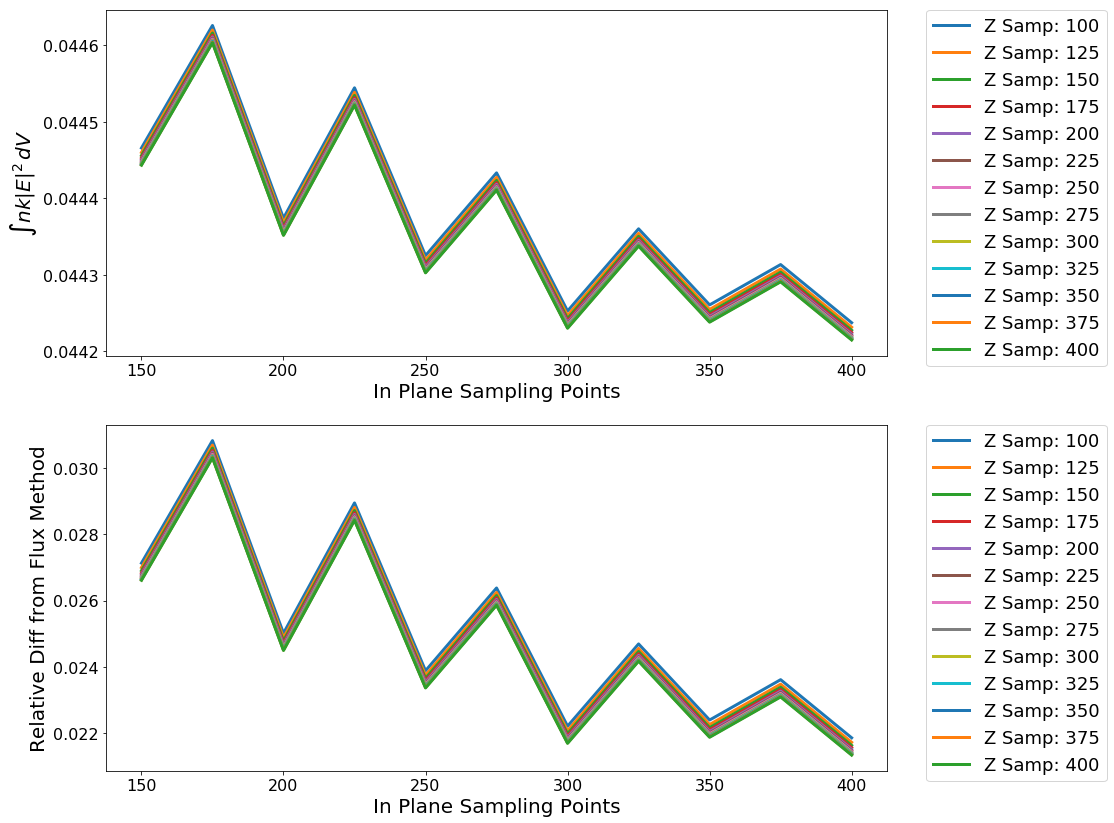

In [109]:
plt.figure()
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(14, 14))
for zsamp in sorted(nw_results_zsamp_keys.keys()):
    plane_samp, power = zip(*sorted(nw_results_zsamp_keys[zsamp]))
    power = np.array(power)
    #print("Plane samp: {}".format(plane_samp))
    #print(zsamps)
    #print(power)
    ax1.plot(plane_samp, power, label="Z Samp: {}".format(zsamp))
    diff = np.abs(power - abs_dict_fluxmethod['NW_AlShell'])/np.abs(abs_dict_fluxmethod['NW_AlShell'])
    ax2.plot(plane_samp, diff, label="Z Samp: {}".format(zsamp))
#plt.legend()
ax1.set_xlabel("In Plane Sampling Points")
ax2.set_xlabel("In Plane Sampling Points")
ax1.set_ylabel(r'$\int n k |E|^2\,dV$')
ax2.set_ylabel("Relative Diff from Flux Method")
ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
#           ncol=2, mode="expand", borderaxespad=0.)
plt.show()

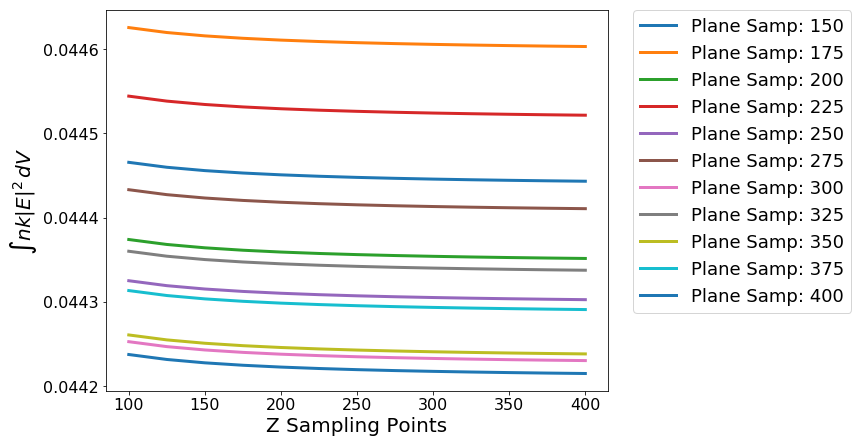

In [96]:
plt.figure()
for plane_samp in sorted(nw_results.keys()):
    zsamps, power = zip(*sorted(nw_results[plane_samp]))
    #print("Plane samp: {}".format(plane_samp))
    #print(zsamps)
    #print(power)
    plt.plot(zsamps, power, label="Plane Samp: {}".format(plane_samp))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel(r'$\int n k |E|^2\,dV$')
plt.xlabel("Z Sampling Points")
plt.show()

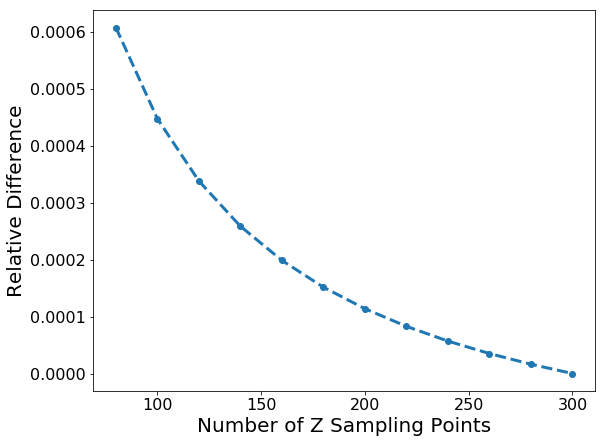

In [67]:
samps, res = map(np.array, zip(*nw_results))
rel_diffs = [abs(res[i] - res[-1])/res[-1] for i in range(len(res))]
plt.figure()
#plt.plot(samps, res)
plt.plot(samps, rel_diffs, '--o')
plt.ylabel("Relative Difference")
plt.xlabel("Number of Z Sampling Points")
plt.show()

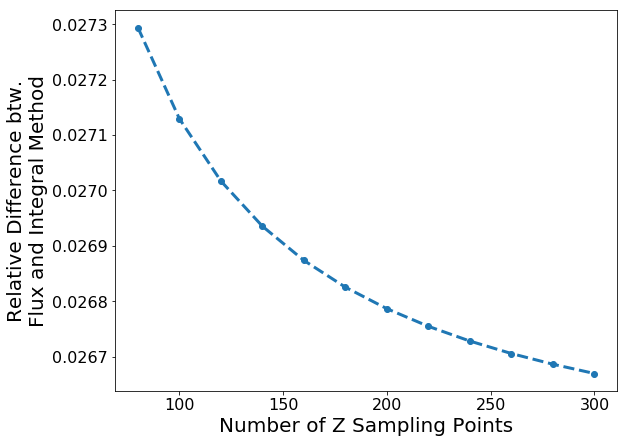

In [68]:
diff = np.abs(res - abs_dict_fluxmethod['NW_AlShell'])/np.abs(abs_dict_fluxmethod['NW_AlShell'])
plt.figure()
plt.plot(samps, diff, '--o')
#plt.plot(samps[:-1], rel_diffs, '--o')
plt.ylabel("Relative Difference btw.\nFlux and Integral Method")
plt.xlabel("Number of Z Sampling Points")
plt.show()

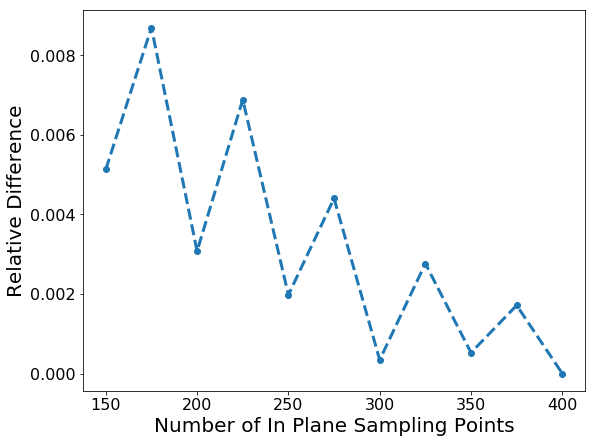

In [71]:
samps, res = map(np.array, zip(*nw_plane_results))
rel_diffs = [abs(res[i] - res[-1])/res[i] for i in range(len(res))]
plt.figure()
#plt.plot(samps, res, '--o')
plt.plot(samps, rel_diffs, '--o')
plt.ylabel("Relative Difference")
plt.xlabel("Number of In Plane Sampling Points")
plt.show()

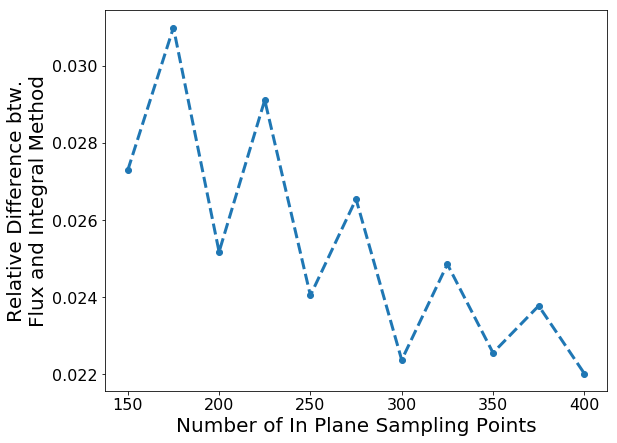

In [74]:
diff = np.abs(res - abs_dict_fluxmethod['NW_AlShell'])/np.abs(abs_dict_fluxmethod['NW_AlShell'])
plt.figure()
plt.plot(samps, diff, '--o')
#plt.plot(samps[:-1], rel_diffs, '--o')
plt.ylabel("Relative Difference btw.\nFlux and Integral Method")
plt.xlabel("Number of In Plane Sampling Points")
plt.show()

### Substrate

## Z Sampling Line Cut Convergence

In [ ]:
pts = np.linspace(0, .25, 10)
xy = list(zip(pts, pts))
xy += list(zip(pts, np.repeat(.125, 10)))

In [ ]:
results = []
for plane_samps in range(150, 300, 50):
    for zsamps in range(800, 1100, 50):
        print("#"*25)
        print("In plane sampling: %i"%plane_samps)
        print("Z sampling %i"%zsamps)
        sim.conf['Simulation']['x_samples'] = plane_samps
        sim.conf['Simulation']['y_samples'] = plane_samps
        sim.conf['Simulation']['z_samples'] = zsamps
        sim.xsamps = plane_samps
        sim.ysamps = plane_samps
        sim.zsamps = zsamps
        sim.make_coord_arrays()
        sim.get_fluxes()
        sim.get_field()
        sim.data['fluxes'] = {record[0].decode():(record[1], record[2]) for record in sim.data['fluxes']}
        abs_dict_fluxmethod, flux_method_total = compute_fluxes(sim)
        
        sim_proc = Simulation(simulator=sim)
        freq = sim_proc.conf[('Simulation', 'params', 'frequency')]
        Esq = sim_proc.normEsquared()
        #normSlice = sim_proc.data['normEsquared'][:, :, 62]
        #plt.matshow(normSlice)
        #plt.show()
        abs_dict_intmethod, int_method_total = get_intmethod_abs(sim_proc)
        errors = get_errors(abs_dict_intmethod, abs_dict_fluxmethod, int_method_total, flux_method_total)
        results.append((plane_samps, zsamps, abs_dict_intmethod, abs_dict_fluxmethod, errors))
        print("Finished iteration")

In [ ]:
results = []
layers = get_layers(sim)
for zsamps in range(800, 1100, 50):
    print("#"*25)
    print("Z sampling %i"%zsamps)
    sim.conf['Simulation']['z_samples'] = zsamps
    sim.zsamps = zsamps
    zmax = sim.get_height()
    z_vals = np.linspace(0, zmax, zsamps)
    for tup in xy:
        x = tup[0]
        y = tup[1]
        print("In plane point: %s"%str(tup))
        arr = np.ones_like(z_vals)
        for name, layer in layers.items():
            n, k = layer.get_nk_at_point(x,y,sim.conf[('Simulation', 'params', 'frequency')])
            inds = np.where((z_vals <= layer.end) & (layer.start <= z_vals))
            arr[inds] *= n*k
        for i, z in enumerate(z_vals):
            Ex, Ey, Ez, _, _, _ = sim.compute_fields_at_point(x, y, z)
            Esq = np.abs(Ex)**2 + np.abs(Ey)**2 + np.abs(Ez)**2 
            arr[i] *= Esq
        results.append((x, y, zsamps, arr))
        print("Finished iteration")

In [ ]:
zmax = sim.get_height()
results_integrated = [(tup[0], tup[1],  tup[2], integrate1d(tup[3], np.linspace(0, zmax, tup[2]))) for tup in results]

In [ ]:
rows = 4
cols = int(np.ceil(len(xy)/rows))
fig, axes = plt.subplots(rows, cols, figsize=(22, 14))
axes = axes.flatten()
for i, pair in enumerate(xy):
    data = [(tup[2], tup[3]) for tup in results_integrated if tup[0] == pair[0] and tup[1] == pair[1]]
    samples, vals = zip(*data)
    axes[i].plot(samples, vals, label="Point = ({:.3f}, {:.3f})".format(*pair))
    axes[i].legend(loc='best')
plt.show()

## In Plane Convergence

In [ ]:
inplane_results = []
abs_dict_fluxmethod, flux_method_total = compute_fluxes(sim)
for plane_samps in range(150, 300, 50):
        print("#"*25)
        print("In plane sampling: %i"%plane_samps)
        print("Z sampling %i"%zsamps)
        sim.conf['Simulation']['x_samples'] = plane_samps
        sim.conf['Simulation']['y_samples'] = plane_samps
        sim.conf['Simulation']['z_samples'] = 800
        sim.xsamps = plane_samps
        sim.ysamps = plane_samps
        sim.zsamps = zsamps
        sim.make_coord_arrays()
        sim.get_field()
        
        sim_proc = Simulation(simulator=sim)
        freq = sim_proc.conf[('Simulation', 'params', 'frequency')]
        #normSlice = sim_proc.data['normEsquared'][:, :, 62]
        #plt.matshow(normSlice)
        #plt.show()
        abs_dict_intmethod, int_method_total = get_intmethod_abs(sim_proc)
        errors = get_errors(abs_dict_intmethod, abs_dict_fluxmethod, int_method_total, flux_method_total)
        inplane_results.append((plane_samps, zsamps, abs_dict_intmethod, abs_dict_fluxmethod, errors))
        print("Finished iteration")

## Volumetric Convergence

In [ ]:
results = []
for plane_samps in range(150, 300, 50):
    for zsamps in range(800, 1100, 50):
        print("#"*25)
        print("In plane sampling: %i"%plane_samps)
        print("Z sampling %i"%zsamps)
        sim.conf['Simulation']['x_samples'] = plane_samps
        sim.conf['Simulation']['y_samples'] = plane_samps
        sim.conf['Simulation']['z_samples'] = zsamps
        sim.xsamps = plane_samps
        sim.ysamps = plane_samps
        sim.zsamps = zsamps
        sim.make_coord_arrays()
        sim.get_fluxes()
        sim.get_field()
        sim.data['fluxes'] = {record[0].decode():(record[1], record[2]) for record in sim.data['fluxes']}
        abs_dict_fluxmethod, flux_method_total = compute_fluxes(sim)
        
        sim_proc = Simulation(simulator=sim)
        freq = sim_proc.conf[('Simulation', 'params', 'frequency')]
        Esq = sim_proc.normEsquared()
        #normSlice = sim_proc.data['normEsquared'][:, :, 62]
        #plt.matshow(normSlice)
        #plt.show()
        abs_dict_intmethod, int_method_total = get_intmethod_abs(sim_proc)
        errors = get_errors(abs_dict_intmethod, abs_dict_fluxmethod, int_method_total, flux_method_total)
        results.append((plane_samps, zsamps, abs_dict_intmethod, abs_dict_fluxmethod, errors))
        print("Finished iteration")

# Fixed z

In [ ]:
planesamps = sorted(list(set(tup[0] for tup in results)))
zsamps = sorted(list(set(tup[1] for tup in results)))
rows = 2
cols = int(np.ceil(len(zsamps)/rows))
fig, axes = plt.subplots(rows, cols, figsize=(16, 11))
axes = axes.flatten()
for i, samp in enumerate(zsamps):
    total_errs = [tup[4]['total'] for tup in sorted(results, key=lambda el: el[0]) if tup[1] == samp]
    nw_errs = [np.real(tup[4]['NW_AlShell'][1]) for tup in sorted(results, key=lambda el: el[0]) if tup[1] == samp]
    ito_errs = [np.real(tup[4]['ITO'][1]) for tup in sorted(results, key=lambda el: el[0]) if tup[1] == samp]
    substrate_errs = [np.real(tup[4]['Substrate'][1]) for tup in sorted(results, key=lambda el: el[0]) if tup[1] == samp]
    axes[i].set_title("Z samps = {}".format(samp))
    axes[i].plot(planesamps, total_errs, '--o', label="Total Percent Error")
    axes[i].plot(planesamps, nw_errs, '--o', label="NW Layer Percent Error")
    axes[i].plot(planesamps, ito_errs, '--o', label="ITO Layer Percent Error")
    axes[i].plot(planesamps, substrate_errs, '--o', label="Substrate Percent Error")
    axes[i].legend(loc='best')
plt.show()

# Fixed plane sampling

In [ ]:
planesamps = sorted(list(set(tup[0] for tup in results)))
zsamps = sorted(list(set(tup[1] for tup in results)))
rows = 1
cols = int(np.ceil(len(planesamps)/rows))
fig, axes = plt.subplots(rows, cols, figsize=(12, 7))
axes = axes.flatten()
for i, samp in enumerate(planesamps):
    total_errs = [tup[4]['total'] for tup in sorted(results, key=lambda el: el[0]) if tup[0] == samp]
    nw_errs = [np.real(tup[4]['NW_AlShell'][1]) for tup in sorted(results, key=lambda el: el[0]) if tup[0] == samp]
    ito_errs = [np.real(tup[4]['ITO'][1]) for tup in sorted(results, key=lambda el: el[0]) if tup[0] == samp]
    substrate_errs = [np.real(tup[4]['Substrate'][1]) for tup in sorted(results, key=lambda el: el[0]) if tup[0] == samp]
    axes[i].set_title("Plane samps = {}".format(samp))
    axes[i].plot(zsamps, total_errs, '--o', label="Total Percent Error")
    axes[i].plot(zsamps, nw_errs, '--o', label="NW Layer Percent Error")
    axes[i].plot(zsamps, ito_errs, '--o', label="ITO Layer Percent Error")
    axes[i].plot(zsamps, substrate_errs, '--o', label="Substrate Percent Error")
    axes[i].legend(loc='best')
plt.show()

In [ ]:
sim_proc.normEsquared()
Esq = sim_proc.data['normEsquared'].copy()

In [ ]:
for layer_name, layer_obj in sim_proc.layers.items():
    #print("Layer: {}".format(layer_name))
    base_unit = sim_proc.conf[('Simulation', 'base_unit')]
    n_mat, k_mat = layer_obj.get_nk_matrix(freq)
    # n and k could be functions of space, so we need to multiply the
    # fields by n and k before integrating
    Esq[layer_obj.slice] *= n_mat*k_mat
#normSlice = Esq[0:270, :, 125]
#normSlice = Esq[:, :, 125]
normSlice = sim_proc.data['normEsquared'][:, :, 125]
plt.matshow(normSlice)
plt.colorbar()
plt.show()

In [ ]:
%%capture
for plane_samps in range(300, 450, 50):
    for zsamps in (800,):
        print("#"*25)
        print("In plane sampling: %i"%plane_samps)
        print("Z sampling %i"%zsamps)
        sim.conf['Simulation']['x_samples'] = plane_samps
        sim.conf['Simulation']['y_samples'] = plane_samps
        sim.conf['Simulation']['z_samples'] = zsamps
        sim.xsamps = plane_samps
        sim.ysamps = plane_samps
        sim.zsamps = zsamps
        sim.make_coord_arrays()
        sim.get_fluxes()
        sim.get_field()
        sim.data['fluxes'] = {record[0].decode():(record[1], record[2]) for record in sim.data['fluxes']}
        abs_dict_fluxmethod, flux_method_total = compute_fluxes(sim)
        
        sim_proc = Simulation(simulator=sim)
        freq = sim_proc.conf[('Simulation', 'params', 'frequency')]
        Esq = sim_proc.normEsquared()
        #normSlice = sim_proc.data['normEsquared'][:, :, 62]
        #plt.matshow(normSlice)
        #plt.show()
        abs_dict_intmethod, int_method_total = get_intmethod_abs(sim_proc)
        errors = get_errors(abs_dict_intmethod, abs_dict_fluxmethod, int_method_total, flux_method_total)
        results.append((plane_samps, zsamps, abs_dict_intmethod, abs_dict_fluxmethod, errors))
        print("Finished iteration")